### Imports 

In [17]:
!pip install scikit-learn

In [18]:
import sklearn
print(sklearn.__version__)

1.1.0


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn import metrics

In [20]:
df = pd.read_csv('transaction_dataset.csv')
df.columns = [x.lower() for x in df.columns]
df

,unnamed: 0,index,address,flag,avg min between sent tnx,avg min between received tnx,time diff between first and last (mins),sent tnx,received tnx,number of created contracts,...,erc20 min val sent,erc20 max val sent,erc20 avg val sent,erc20 min val sent contract,erc20 max val sent contract,erc20 avg val sent contract,erc20 uniq sent token name,erc20 uniq rec token name,erc20 most sent token type,erc20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,2178,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Accounts = 9841
#Flagged accounts = 2179
Percentage of flagged accounts = 22.14 %


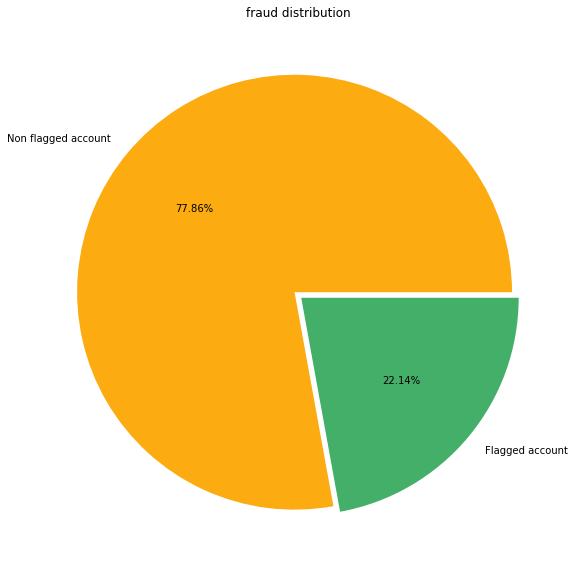

In [21]:
total = df.shape[0]
total_frauds = df["flag"].sum()
print("#Accounts = " + str(total) + "\n" "#Flagged accounts = " + str(total_frauds))
print("Percentage of flagged accounts = " + str(round(total_frauds / total, 4) * 100) + " %")
 
pie, ax = plt.subplots(figsize=[15,10])
labels = [ 'Non flagged account','Flagged account']
colors = ['#FCAB10', '#44AF69']
plt.pie(x = df['flag'].value_counts(), labels = labels, colors = colors, explode=[0.02] * 2,  autopct='%.2f%%')
plt.title('fraud distribution')
plt.show()

We can see that there is a huge dataset inbalance 

In [22]:
cols_to_drop = [
    ' erc20 most sent token type',
    ' erc20_most_rec_token_type',
    'address',
    'index',
    'unnamed: 0'
]

features = [x for x in df.columns if (x != 'flag' and x not in cols_to_drop)]

In [23]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 45 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   avg min between sent tnx                              9841 non-null   float64
 1   avg min between received tnx                          9841 non-null   float64
 2   time diff between first and last (mins)               9841 non-null   float64
 3   sent tnx                                              9841 non-null   int64  
 4   received tnx                                          9841 non-null   int64  
 5   number of created contracts                           9841 non-null   int64  
 6   unique received from addresses                        9841 non-null   int64  
 7   unique sent to addresses                              9841 non-null   int64  
 8   min value received                                    9841

### Building a baseline model


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin


class BasePipeStep(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        return X
    
class SelectColumns(BasePipeStep):
    
    def transform(self, X):
        X = X.copy()
        return X[self.columns]
    
class FillNumericData(BasePipeStep):
    
    def fit(self, X, y=None):
        self.means = { col: X[col].mean() for col in self.columns}
        return self
        
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(self.means[col])
        return X


class ScaleNumeric(BasePipeStep):
    
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.columns])
        return self
        
    def transform(self, X):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

In [9]:
preprocessing = Pipeline([
    ('feature_selection', SelectColumns(features)),
    ('fill_missing', FillNumericData(features)),
    ('standard_scaling', ScaleNumeric(features)),
])

pipeline = Pipeline([
    ('preprocessing', preprocessing),
#     ('create_new_features', features),
    ('learning', XGBClassifier(random_state=42, eval_metric='auc',
              objective='binary:logistic') )
])

pipeline1 = Pipeline([
    ('learning', XGBClassifier(random_state=42, eval_metric='auc',
              objective='binary:logistic') )
])

In [10]:
X = df[features]
y = df['flag']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [11]:
df.columns[df.isna().any()].tolist()

[' total erc20 tnxs',
 ' erc20 total ether received',
 ' erc20 total ether sent',
 ' erc20 total ether sent contract',
 ' erc20 uniq sent addr',
 ' erc20 uniq rec addr',
 ' erc20 uniq sent addr.1',
 ' erc20 uniq rec contract addr',
 ' erc20 avg time between sent tnx',
 ' erc20 avg time between rec tnx',
 ' erc20 avg time between rec 2 tnx',
 ' erc20 avg time between contract tnx',
 ' erc20 min val rec',
 ' erc20 max val rec',
 ' erc20 avg val rec',
 ' erc20 min val sent',
 ' erc20 max val sent',
 ' erc20 avg val sent',
 ' erc20 min val sent contract',
 ' erc20 max val sent contract',
 ' erc20 avg val sent contract',
 ' erc20 uniq sent token name',
 ' erc20 uniq rec token name',
 ' erc20 most sent token type',
 ' erc20_most_rec_token_type']

### SMOTE  

In [107]:
!pip install imbalanced-learn

In [108]:
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# define resampling
over = RandomOverSampler(sampling_strategy=0.59)
under = RandomUnderSampler(sampling_strategy=0.8)

# define pipeline
pipeline_ov_un = Pipeline(steps=[ ('feature_selection', SelectColumns(features)),
    ('fill_missing', FillNumericData(features)),
    ('standard_scaling', ScaleNumeric(features)),('o', over), ('u', under)])

In [109]:
X_train_resampled, y_train_resampled = pipeline_ov_un.fit_resample(X_train, y_train)

In [110]:
X_train.shape

(6593, 45)

In [111]:
y_train_resampled

0       0
1       0
2       0
3       0
4       0
       ..
6810    1
6811    1
6812    1
6813    1
6814    1
Name: flag, Length: 6815, dtype: int64

In [112]:
total = X_train_resampled.shape[0]
total_frauds = y_train_resampled.sum()
print("#Accounts = " + str(total) + "\n" "#Flagged accounts = " + str(total_frauds))
print("Percentage of flagged accounts = " + str(round(total_frauds / total, 4) * 100) + " %")

#Accounts = 6815
#Flagged accounts = 3029
Percentage of flagged accounts = 44.45 %


In [113]:
total = X_train.shape[0]
total_frauds = y_train.sum()
print("#Accounts = " + str(total) + "\n" "#Flagged accounts = " + str(total_frauds))
print("Percentage of flagged accounts = " + str(round(total_frauds / total, 4) * 100) + " %")

#Accounts = 6593
#Flagged accounts = 1458
Percentage of flagged accounts = 22.11 %


## Import the data 

In [85]:
newdf = pd.read_csv("preprocessed_data.csv")

In [86]:
newdf.columns

Index(['Unnamed: 0', 'index', 'address', 'flag', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received', 'total_ether_balance',
       'total_erc20_tnxs', 'erc20_total_ether_received',
       'erc20_total_ether_sent', 'erc20_total_ether_sent_contract',
       'erc20_uniq_sent_addr', 'erc20_uniq_rec_addr',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc20_min_val_sent',
       'erc20_max_val_sent', 'erc20_avg_val_sent',
       'erc20_uniq_sent_token_name', 'erc20_uniq_rec_token_name'],
      dtype='ob

In [87]:
newdf.columns = [x.lower() for x in newdf.columns]
newdf.columns

Index(['unnamed: 0', 'index', 'address', 'flag', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received', 'total_ether_balance',
       'total_erc20_tnxs', 'erc20_total_ether_received',
       'erc20_total_ether_sent', 'erc20_total_ether_sent_contract',
       'erc20_uniq_sent_addr', 'erc20_uniq_rec_addr',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc20_min_val_sent',
       'erc20_max_val_sent', 'erc20_avg_val_sent',
       'erc20_uniq_sent_token_name', 'erc20_uniq_rec_token_name'],
      dtype='ob

In [88]:
newdf.columns = [x.lower() for x in newdf.columns]

y = newdf['flag']
newdf = newdf.drop("flag", axis = 1)
X = newdf
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

### Training 

In [89]:
X_train

,unnamed: 0,index,address,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,...,erc20_uniq_rec_addr,erc20_uniq_rec_contract_addr,erc20_min_val_rec,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
1454,1454,1455,0x250f31deae11008bb9b03c648a6b3af8f3d7480b,0.00,0.00,14436.70,1,1,0,1,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
8914,8939,1278,0x93574d7c405717d80520944ee1cb72d327b01df5,241.55,66.07,4160.50,3,52,0,49,...,1.0,1.0,567580.000000,5.675800e+05,567580.000000,0.00,0.000000,0.000000,0.0,1.0
9728,9753,2092,0xf605c1c8c1cd6bc3aa6f7383b86226c583ab2775,0.00,35.47,1542.87,1,37,0,29,...,1.0,1.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,1.0
3869,3894,962,0x67a46c85a6b65247836b2d13f0cd6ba666f6486d,159.34,0.99,320.67,2,2,0,2,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
2521,2521,2522,0x41d816da5b5f04151112c66711befb1ec052582e,6.18,3296.21,6604.78,2,2,0,1,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5759,2827,0x9973a1b1ce2965b3f58ae9a340fb2a40439734ff,1364.83,8666.03,154073.18,24,14,0,6,...,1.0,1.0,11.279754,1.250723e+01,11.893493,23.78,23.780000,23.780000,1.0,1.0
5191,5216,2284,0x8a34092e6e43cac0e61ca4f63bcd7e99fee60349,2.20,0.52,9.82,4,2,0,2,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
5390,5415,2483,0x8fe12253e2300cb1868d348d758263473edd86ff,659.73,224.64,1308251.62,1982,3,0,2,...,26.0,29.0,0.000000,2.018061e+04,88.006691,0.01,6416.872299,33.736656,3.0,28.0
860,860,861,0x151f9b0c0d9e4aaedc17feb6d698f96c5e9c75ef,165.15,0.00,330.30,2,2,0,2,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0


In [90]:
X_train.drop("index", axis =1) 
X_train.drop("address", axis =1) 


,unnamed: 0,index,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,unique_sent_to_addresses,...,erc20_uniq_rec_addr,erc20_uniq_rec_contract_addr,erc20_min_val_rec,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
1454,1454,1455,0.00,0.00,14436.70,1,1,0,1,1,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
8914,8939,1278,241.55,66.07,4160.50,3,52,0,49,3,...,1.0,1.0,567580.000000,5.675800e+05,567580.000000,0.00,0.000000,0.000000,0.0,1.0
9728,9753,2092,0.00,35.47,1542.87,1,37,0,29,1,...,1.0,1.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,1.0
3869,3894,962,159.34,0.99,320.67,2,2,0,2,2,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
2521,2521,2522,6.18,3296.21,6604.78,2,2,0,1,2,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5759,2827,1364.83,8666.03,154073.18,24,14,0,6,11,...,1.0,1.0,11.279754,1.250723e+01,11.893493,23.78,23.780000,23.780000,1.0,1.0
5191,5216,2284,2.20,0.52,9.82,4,2,0,2,4,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0
5390,5415,2483,659.73,224.64,1308251.62,1982,3,0,2,3,...,26.0,29.0,0.000000,2.018061e+04,88.006691,0.01,6416.872299,33.736656,3.0,28.0
860,860,861,165.15,0.00,330.30,2,2,0,2,2,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.0,0.0


In [91]:
X_test.drop("index", axis =1) 
X_test.drop("address", axis =1) 

,unnamed: 0,index,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,unique_sent_to_addresses,...,erc20_uniq_rec_addr,erc20_uniq_rec_contract_addr,erc20_min_val_rec,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
7718,7743,82,0.00,339.31,193813.48,1,31,0,22,1,...,2.0,3.0,0.000000,1.337000,0.445667,0.0,0.0,0.0,0.0,3.0
3894,3919,987,3.50,3886.85,7780.70,2,2,0,2,2,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
9314,9339,1678,0.00,261.82,23289.00,1,3,0,3,1,...,0.0,0.0,0.000000,0.000000,0.000000,100.0,100.0,100.0,1.0,0.0
3593,3618,686,154.92,0.00,309.83,2,1,0,1,2,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5838,5863,2931,0.00,0.00,1.57,1,1,0,1,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9553,9578,1917,0.00,34674.11,173370.53,0,5,1,3,0,...,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
2579,2579,2580,0.00,961.93,1929.48,1,2,0,2,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4787,4812,1880,0.00,17442.96,226758.45,0,13,1,5,0,...,2.0,2.0,0.264862,2.257531,1.261197,0.0,0.0,0.0,0.0,2.0
9377,9402,1741,0.00,0.00,2776.35,1,1,0,1,1,...,1.0,1.0,13.370000,13.370000,13.370000,0.0,0.0,0.0,0.0,1.0


In [96]:
X_test.shape
X_train.shape

(6576, 36)

In [93]:
X_train._get_numeric_data().columns


Index(['unnamed: 0', 'index', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received', 'total_ether_balance',
       'total_erc20_tnxs', 'erc20_total_ether_received',
       'erc20_total_ether_sent', 'erc20_total_ether_sent_contract',
       'erc20_uniq_sent_addr', 'erc20_uniq_rec_addr',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc20_min_val_sent',
       'erc20_max_val_sent', 'erc20_avg_val_sent',
       'erc20_uniq_sent_token_name', 'erc20_uniq_rec_token_name'],
      dtype='object')

In [94]:
pipeline1.fit(X_train._get_numeric_data(),  np.ravel(y_train, order='C'))

C:\Users\tziya\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('learning',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [64]:
import xgboost as xgb
model = XGBClassifier(random_state=42, eval_metric='auc',
              objective='binary:logistic')

model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.address

In [97]:
from sklearn.model_selection import cross_val_score

#X_test.columns = X_test.columns.str.replace('[_]', ' ')
  
test_prediction = pipeline1.predict_proba(X_test._get_numeric_data())[:,1]

score = metrics.roc_auc_score(y_test, test_prediction)

print(f'Area under ROC of Model On Test Set - {score:,.2%}')

Area under ROC of Model On Test Set - 99.98%


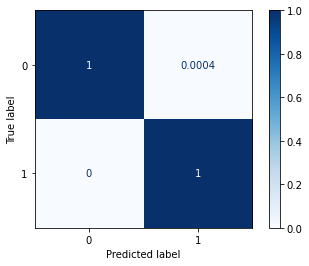

In [103]:
test_prediction = pipeline1.predict(X_test._get_numeric_data())

disp = metrics.plot_confusion_matrix(pipeline1, X_test._get_numeric_data(), y_test,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')